In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

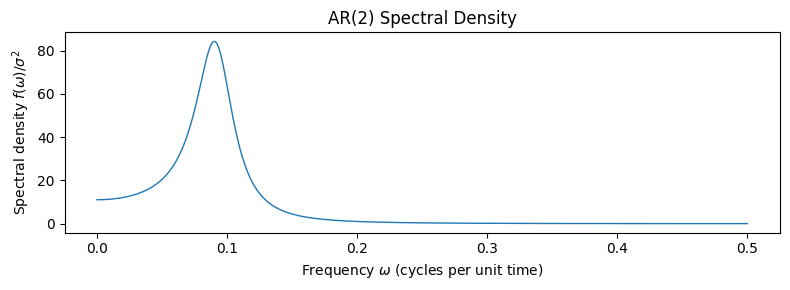

In [2]:
omega = np.linspace(0, 0.5, 1000)
phi_z = 1 - 1.5 * np.exp(-2j * np.pi * omega) + 0.8 * np.exp(-4j * np.pi * omega)
f_ar2 = 1.0 / np.abs(phi_z)**2

plt.figure(figsize=(8, 3))
plt.plot(omega, f_ar2, linewidth=1)
plt.xlabel('Frequency $\\omega$ (cycles per unit time)')
plt.ylabel('Spectral density $f(\\omega) / \\sigma^2$')
plt.title('AR(2) Spectral Density')
plt.tight_layout()
plt.show()

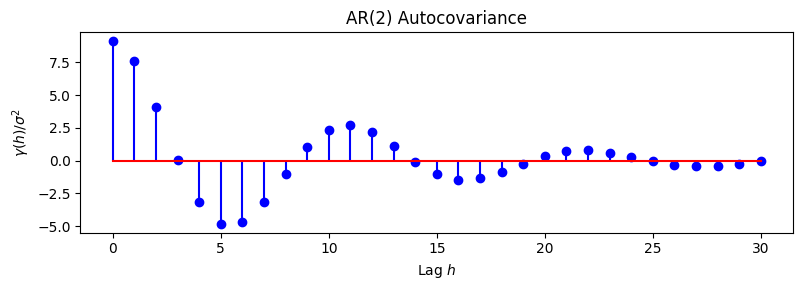

In [3]:
ar_poly = np.array([1, -1.5, 0.8])
ma_poly = np.array([1.0])
arma_process = ArmaProcess(ar_poly, ma_poly)
max_lag = 30
acov = arma_process.acovf(nobs=max_lag + 1)

plt.figure(figsize=(8, 3))
plt.stem(range(max_lag + 1), acov, linefmt='b-', markerfmt='bo', basefmt='r-')
plt.xlabel('Lag $h$')
plt.ylabel('$\\gamma(h) / \\sigma^2$')
plt.title('AR(2) Autocovariance')
plt.tight_layout()
plt.show()

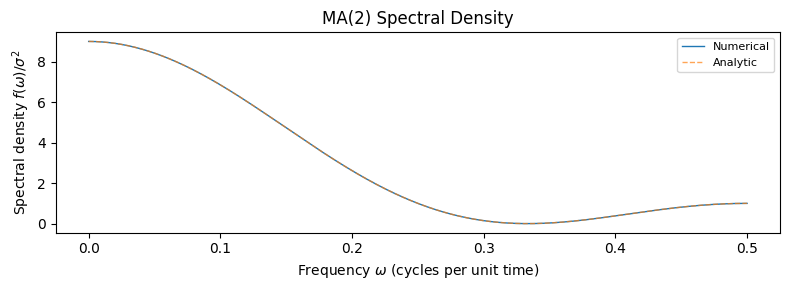

In [ ]:
omega = np.linspace(0, 0.5, 1000)
theta_z = 1 + np.exp(-2j * np.pi * omega) + np.exp(-4j * np.pi * omega)
f_ma2 = np.abs(theta_z)**2
f_ma2_analytic = (1 + 2 * np.cos(2 * np.pi * omega))**2

plt.figure(figsize=(8, 3))
plt.plot(omega, f_ma2, linewidth=1)
plt.xlabel('Frequency $\\omega$ (cycles per unit time)')
plt.ylabel('Spectral density $f(\\omega) / \\sigma^2$')
plt.title('MA(2) Spectral Density')
plt.tight_layout()
plt.show()

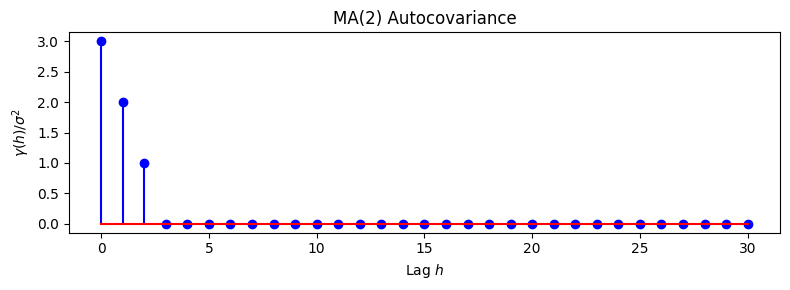

In [5]:
gamma = np.zeros(max_lag + 1)
gamma[0] = 3.0
gamma[1] = 2.0
gamma[2] = 1.0

plt.figure(figsize=(8, 3))
plt.stem(range(max_lag + 1), gamma, linefmt='b-', markerfmt='bo', basefmt='r-')
plt.xlabel('Lag $h$')
plt.ylabel('$\\gamma(h) / \\sigma^2$')
plt.title('MA(2) Autocovariance')
plt.tight_layout()
plt.show()

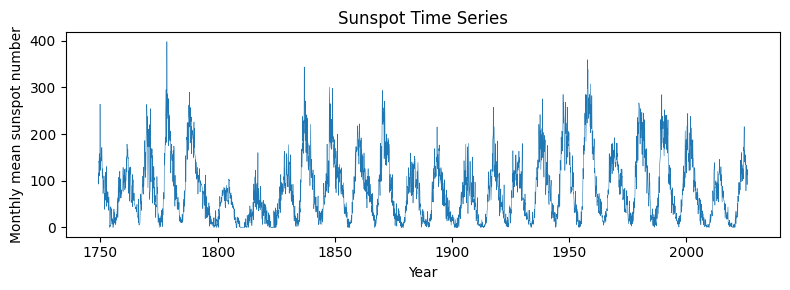

In [6]:
dat = pd.read_csv('sunspots.txt', sep='\\s+', comment='#')
dat.columns = ['Year', 'Month', 'Time', 'Number', 'Std', 'Nobs']
dat = dat[dat['Number'] >= 0].reset_index(drop=True)
sunspot = dat['Number'].values
time_frac = dat['Time'].values

plt.figure(figsize=(8, 3))
plt.plot(time_frac, sunspot, linewidth=0.4)
plt.xlabel('Year')
plt.ylabel('Monthly mean sunspot number')
plt.title('Sunspot Time Series')
plt.tight_layout()
plt.show()

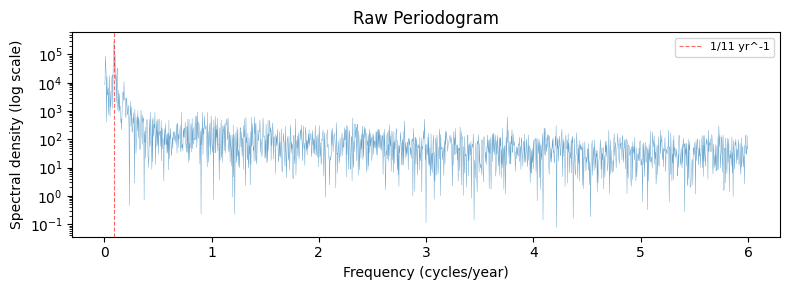

In [7]:
freqs, psd_raw = signal.periodogram(sunspot, fs=12.0, detrend='linear')

plt.figure(figsize=(8, 3))
plt.semilogy(freqs[1:], psd_raw[1:], linewidth=0.3, alpha=0.7)
plt.xlabel('Frequency (cycles/year)')
plt.ylabel('Spectral density (log scale)')
plt.axvline(x=1/11, color='red', linestyle='--', linewidth=0.8, alpha=0.6, label='1/11 yr^-1')
plt.legend(fontsize=8)
plt.title('Raw Periodogram')
plt.tight_layout()
plt.show()

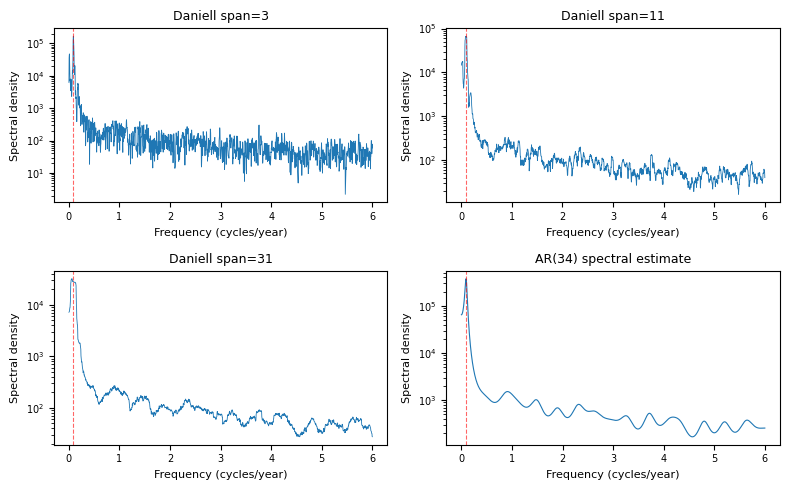

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(8, 5))

spans = [3, 11, 31]
titles = ['Daniell span=3', 'Daniell span=11', 'Daniell span=31']

for i, span in enumerate(spans):
    ax = axes[i // 2, i % 2]
    kernel = np.ones(span) / span
    psd_smooth = np.convolve(psd_raw, kernel, mode='same')
    ax.semilogy(freqs[1:], psd_smooth[1:], linewidth=0.6)
    ax.axvline(x=1/11, color='red', linestyle='--', linewidth=0.8, alpha=0.6)
    ax.set_title(titles[i], fontsize=9)
    ax.set_xlabel('Frequency (cycles/year)', fontsize=8)
    ax.set_ylabel('Spectral density', fontsize=8)
    ax.tick_params(labelsize=7)

sel = ar_select_order(sunspot, maxlag=50, ic='aic')
best_ar_order = sel.ar_lags[-1]
ar_model = AutoReg(sunspot, lags=best_ar_order).fit()
ar_coeffs_fit = ar_model.params[1:]
sigma2_hat = ar_model.sigma2

omega_grid = np.linspace(0, 6.0, 2000)
phi_z = np.ones(len(omega_grid), dtype=complex)
for k in range(len(ar_coeffs_fit)):
    phi_z -= ar_coeffs_fit[k] * np.exp(-2j * np.pi * omega_grid * (k + 1) / 12.0)
f_ar = sigma2_hat / np.abs(phi_z)**2

ax = axes[1, 1]
ax.semilogy(omega_grid, f_ar, linewidth=0.8)
ax.axvline(x=1/11, color='red', linestyle='--', linewidth=0.8, alpha=0.6)
ax.set_title(f'AR({best_ar_order}) spectral estimate', fontsize=9)
ax.set_xlabel('Frequency (cycles/year)', fontsize=8)
ax.set_ylabel('Spectral density', fontsize=8)
ax.tick_params(labelsize=7)

plt.tight_layout()
plt.show()